## Exercise 3 - PySpark 

1. Compute the average word length of shakespeare.txt.
2. Compute the word length distribution of shakespeare.txt.
3. Find the most frequent words of shakespeare.txt.
4. Count the number of words of shakespeare.txt starting with each letter of the alphabet.
5. Find the words pair most co-occurring next to each other of shakespeare.txt

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import re

from pyspark import SparkContext
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
# prevent useless logging messages
sc.setLogLevel("ERROR")

In [2]:
server_number = "12"
hdfs_path_file = "hdfs://kddrtserver{0}.isti.cnr.it:9000/hpsa/datasets/shakespeare.txt".format(server_number)
shakespeare_rdd = sc.textFile(hdfs_path_file)

In [3]:
shakespeare_rdd.take(10)

['This is the 100th Etext file presented by Project Gutenberg, and',
 'is presented in cooperation with World Library, Inc., from their',
 'Library of the Future and Shakespeare CDROMS.  Project Gutenberg',
 'often releases Etexts that are NOT placed in the Public Domain!!',
 '',
 'Shakespeare',
 '',
 '*This Etext has certain copyright implications you should read!*',
 '',
 '<<THIS ELECTRONIC VERSION OF THE COMPLETE WORKS OF WILLIAM']

In [4]:
# Clean the rdd of lines lowering the upper case characters and removing the non [a-z0-9 ] characters
pattern = re.compile("[^a-z0-9 ]+")
shakespeare_clean_rdd = shakespeare_rdd.map(lambda line: pattern.sub(' ', line.lower()))

### Ex1 - Average word length

In [17]:
rdd_word_len = shakespeare_clean_rdd \
    .flatMap(lambda x: [len(w) for w in x.split(' ')]) \
    .filter(lambda x: x>0)
rdd_word_len.take(20)

[4, 2, 3, 5, 5, 4, 9, 2, 7, 9, 3, 2, 9, 2, 11, 4, 5, 7, 3, 4]

In [18]:
rdd_word_len.sum(), rdd_word_len.count(), rdd_word_len.sum()/rdd_word_len.count()

(699839, 171541, 4.079718551250139)

### Ex2 - Word length distribution

In [21]:
rdd_word_len_dist = rdd_word_len \
    .map(lambda x: (x, 1)) \
    .reduceByKey(lambda x,y: x+y)

rdd_word_len_dist.collect()

[(4, 38089),
 (2, 29875),
 (6, 13961),
 (8, 6520),
 (12, 248),
 (10, 2056),
 (14, 17),
 (3, 35105),
 (5, 20220),
 (9, 3517),
 (7, 9950),
 (11, 730),
 (1, 11168),
 (13, 79),
 (15, 6)]

In [22]:
len_w, count_len_w = zip(*rdd_word_len_dist.collect())

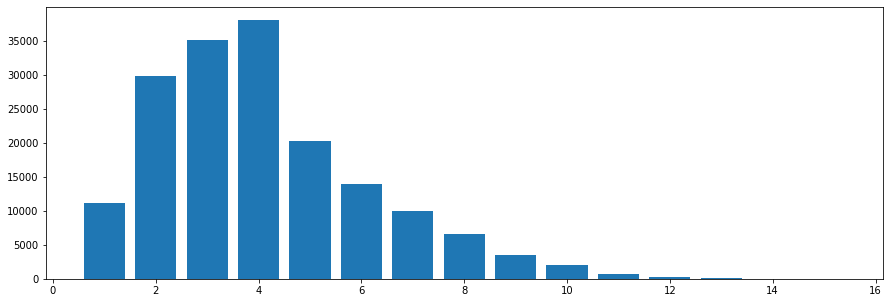

In [24]:
plt.figure(figsize=(15,5))
plt.bar(
    x=len_w, height=count_len_w
)
plt.show()

### Ex3 - Most frequent words

In [26]:
rdd_word = shakespeare_clean_rdd \
    .flatMap(lambda x: [w for w in x.split(' ')]) \
    .filter(lambda x: len(x)>0)
rdd_word.take(5)

['this', 'is', 'the', '100th', 'etext']

In [31]:
rdd_word \
    .map(lambda x: (x,1)) \
    .reduceByKey(lambda x,y:x+y) \
    .takeOrdered(10, (lambda pair: -pair[1]))

[('the', 4893),
 ('and', 4440),
 ('i', 4254),
 ('to', 3775),
 ('of', 3435),
 ('you', 2855),
 ('a', 2547),
 ('that', 2261),
 ('my', 2185),
 ('in', 2075)]

### Ex4 - Number of words starting with each letter

In [40]:
rdd_word = shakespeare_clean_rdd \
    .flatMap(lambda x: [w for w in x.split(' ')]) \
    .filter(lambda x: len(x)>0)


lst = rdd_word.map(lambda w: (w[0],1)) \
    .reduceByKey(lambda x,y: x+y) \
    .sortByKey() \
    .collect()

letter, letter_count = zip(*lst)

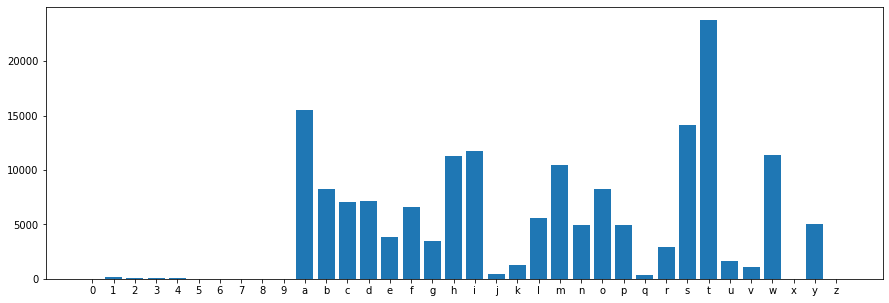

In [41]:
plt.figure(figsize=(15,5))
plt.bar(
    x=letter, height=letter_count
)
plt.show()

### Ex5 - Most correlated words

In [46]:
def line_to_bigram(line):
    words = line.split()
    return [(words[i-1], words[i]) for i in range(1, len(words))]

shakespeare_clean_rdd\
    .flatMap(lambda x: line_to_bigram(x))\
    .map(lambda bigram: (bigram, 1))\
    .reduceByKey(lambda x,y: x+y)\
    .takeOrdered(10, (lambda pair: -pair[1]))

[(('i', 'am'), 344),
 (('i', 'have'), 321),
 (('i', 'll'), 308),
 (('of', 'the'), 305),
 (('in', 'the'), 259),
 (('i', 'will'), 247),
 (('to', 'the'), 238),
 (('of', 'syracuse'), 233),
 (('antipholus', 'of'), 202),
 (('it', 'is'), 200)]